### Imports

In [1]:
import json
import pandas as pd
import re
import string
import unidecode
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import random

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve

### Read data

La data se ha descargado del enlace: http://jmcauley.ucsd.edu/data/amazon/
<br>*Nota:* los archivos que continen los datos pesan demasiado como para subirlos mediante git.

In [3]:
filename = "data/reviews_Patio_Lawn_and_Garden_5.json"
reviews = []
for line in open(filename, 'r'):
    reviews.append(json.loads(line))
reviews = json.dumps(reviews)

In [4]:
data = pd.read_json(reviews)

In [5]:
data = data[['reviewText', 'overall']]

In [6]:
data.loc[0, 'reviewText']

'Good USA company that stands behind their products. I have had to warranty two hoses and they send replacements right out to you. I had one burst after awhile, you could see it buldge for weeks before it went so no suprises. The other one was winter related as I am bad and leave them out most of the time. Highly reccomend. Note the hundred footer is heavy and like wresting an anaconda when its time to put away, but it does have a far reach.'

### Dividir en train/test

In [7]:
# Keep the 10% for testing
data_test = data.sample(frac = 0.25)

# The rest for training
data = data.drop(index=data_test.index)

### Preprocesado

In [8]:
data.isnull().sum()

reviewText    0
overall       0
dtype: int64

Aparentemente no hay nulos, pero vamos a comprobarlo, ya que al tratarse de texto muchas veces estos nulos aparecen en forma de "\n", " " o emoticonos.

In [9]:
data['reviewText'].sort_values()

128                                                       
9079                                                      
13082                                                     
9314                                                      
10109                                                     
                               ...                        
6014     wow! At first I put this sideways so the indic...
1198     wow! I just may have green thumb, brought jobe...
12051    wow!!! I must say that I noticed drastic chang...
9745     you should try this!  I have used pre-emergent...
10350    you will not go wrong with this combination . ...
Name: reviewText, Length: 9954, dtype: object

Vemos que, efectivamente hay instancias que debemos descartar ya que si que tienen la review vacia.

In [10]:
def remove_accents(text):
    if text:
        unaccented_string = unidecode.unidecode(text)
        return unaccented_string
    return ""

def remove_punctuation_marks(text):
    if text:
        translator = str.maketrans('', '', string.punctuation)
        return text.translate(translator)
    return ""

def text_to_lower_case(text):
    if text:
        # Convertir a minusculas 
        # (aunque más adelante el tf-idf vectorizer lo hace automático, 
        #lo hacemos como paso del procesamiento del texto.
        return text.lower()
    return ""

def remove_emojis(text):
    if text:
        str_enc = text.encode(encoding = 'ascii', errors = 'ignore')
        return str_enc.decode(encoding = 'ascii', errors='ignore')
    return ""

def remove_multiple_whitespaces(text):
    if text:
        return re.sub(' +', ' ', text).strip()
    return ""

def remove_text_marks(text):
    if text:
        # Reemplazamos it's por its
        text = re.sub(r"\'","", text)
        # Reemplazamos *, ?, ... por espacios
        text = re.sub(r'[^\w]', " ", text)
        return text.strip()
    
    return ""

def remove_alone_numbers(text):
    if text:
        text = re.sub(r"\d"," ", text)
        return text
    
    return ""


In [11]:
def clean_text(text):
    text = text_to_lower_case(text)
    text = remove_text_marks(text)
    text = remove_punctuation_marks(text)
    text = remove_accents(text)
    text = remove_emojis(text)
    text = remove_alone_numbers(text)
    text = remove_multiple_whitespaces(text)
    
    # Return
    return text

In [12]:
data['Text_Clean'] = data.reviewText.apply(lambda text: clean_text(text))

In [13]:
data[["reviewText", "Text_Clean"]].tail(1).values

array([["When I first saw these, I thought &#34;Hmmm. Wonder if they're legal as weapons?&#34;  Hey, I'm a knife collector!  Just putting it out there - these would make one heck of a weapon.  They are designed to grip meat, shred pork and more.  They are surprisingly sharp and strong.  I look forward to using them the next time I need to BBQ a bunch of steaks on the grill.",
        'when i first saw these i thought hmmm wonder if theyre legal as weapons hey im a knife collector just putting it out there these would make one heck of a weapon they are designed to grip meat shred pork and more they are surprisingly sharp and strong i look forward to using them the next time i need to bbq a bunch of steaks on the grill']],
      dtype=object)

In [14]:
idx = np.array(data[data.Text_Clean == ''].index)
data.drop(idx, axis = 0, inplace = True)

In [15]:
data.Text_Clean.sort_values()

1298     a baby red squirrel well this is his dream buf...
4416     a bad back is a problem when you like to garde...
8794     a bag of catfood in the laundry room closet go...
1520     a bird feeder is an act of kindness from one s...
1551     a bit disappointed in the quality of this trim...
                               ...                        
10350    you will not go wrong with this combination th...
12746    you will not have a hard time putting this tog...
3033     you wouldnt think that a way splitter would be...
9188     your house is sitting on the stream we drank f...
4065     youre not going to leave this out over the win...
Name: Text_Clean, Length: 9943, dtype: object

### EDA

Usaremos la libreria NLTK

In [16]:
def convert_to_nltk_text(data, 
                         text_field):
    tokens = []
    for text in data[text_field].values:
        tokens.extend(text.split(" "))

    return nltk.Text(tokens)

In [17]:
nltk_text = convert_to_nltk_text(data, "Text_Clean")

Vamos a ver primero la **distribucion del vocabulario** y volveremos a esto una vez hayamos limpiado el texto para ver como cambia:

In [18]:
freq_dist = nltk.FreqDist(nltk_text)

- Cuantas veces aparece una palabra en el texto:

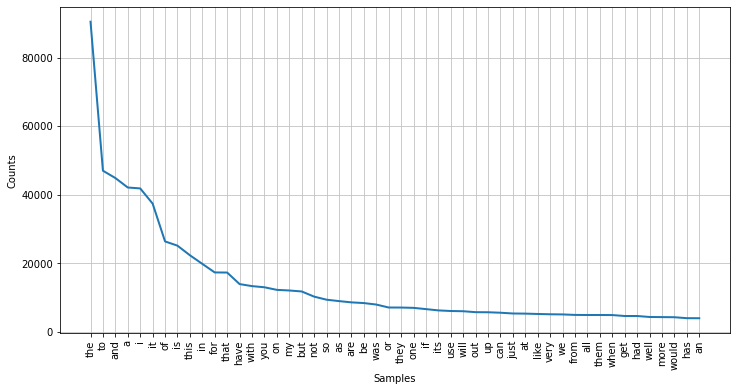

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [19]:
plt.figure(figsize = (12, 6))
freq_dist.plot(50)

Con esto vemos que las palabras que más aparecen no son para nada aquellas que más información aportan al sentimiento del texto. <br> Es por esto que vamos a limpiar el texto quitando las stopwords y haciendo stemming.
<br> Las palabras más importantes son aquellas que aparecen poco pero proporcionan significado

In [20]:
def get_tokens(text):
    if isinstance(text, nltk.Text):
        tokens = text.tokens
    else:
        tokens = text.split(" ")
    
    return tokens

def remove_stopwords(text, 
                     language):
    # Import stopwords
    from nltk.corpus import stopwords
    
    stopwords_list = stopwords.words(language)
    
    tokens = get_tokens(text)
        
    cleaned_text = [tokens[i] for i in range(len(tokens)) if tokens[i] not in stopwords_list]
    
    if isinstance(text, nltk.Text):
        output = nltk.Text(cleaned_text)
    else:
        output = " ".join(cleaned_text)
    
    return output

def stem_text(text,
              language):
   
    from nltk.stem.snowball import SnowballStemmer
   
    stemmer = SnowballStemmer(language)
    
    tokens = get_tokens(text)
    
    stemmas = [stemmer.stem(word) for word in tokens]
    
    if isinstance(text, nltk.Text):
        output = nltk.Text(stemmas)
    else:
        output = " ".join(stemmas)
    
    return output

def standardize_text(text,
                     language):
    # Remove the stop words
    standardized_text = remove_stopwords(text, language)
    
    # Stemming
    standardized_text = stem_text(standardized_text, language)
    #standardized_text = stem_text(text, language)
    
    # Return
    return standardized_text

*------------------------------------------------------------*<br>
Para hacer la prueba sin hacer el paso de remove_stopwords comentamos la primera linea de codigo de la funcion standardize_text

In [21]:
data['Standardized_Text'] = data.Text_Clean.apply(lambda text: standardize_text(text, "english"))

Volvemos a visualizar la distribucion del vocabulario y comparamos con el grafico anterior:

In [22]:
standardized_nltk_text = standardize_text(nltk_text, "english")

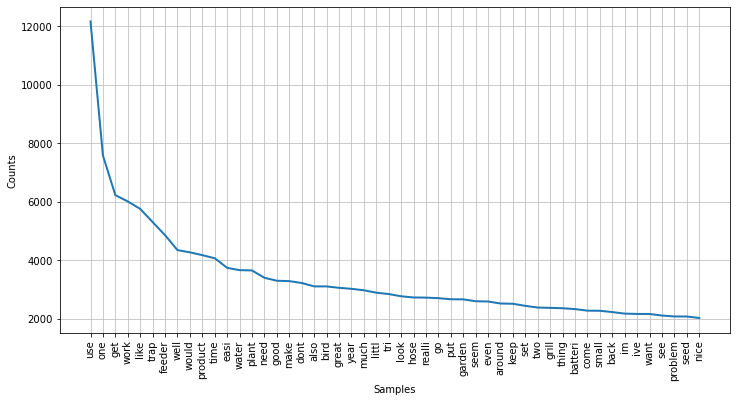

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [23]:
plt.figure(figsize = (12, 6))
nltk.FreqDist(standardized_nltk_text).plot(50)

Podemos ver, para empezar que la máxima frecuencia es mucho más baja que en el gráfico anterior. Esto significa que las palabras más frecuentes, que normalmente son aquellas sin significado llamadas "stopwords" se han eliminado y nos hemos quedado con un vocabulario relevante e informativo para predecir el sentimiento del usuario.

*------------------------------------------------------------*<br>
Tras hacer la prueba de quitar stopwords, vemos que el grafico se mantiene como el primero y aunque las palabras "normalizadas" seguimos teniendo muchas palabras sin significado que, además, aparecen muchas veces en el texto introduciendo ruido en el texto. <br> Más abajo reentrenamos el modelo y vemos como ha afectado este cambio en el preprocesado. 

### Get data ready for training the models

#### Convertir a problema de clasificacion

In [24]:
def star_sentiment_matching(value):
    if value <3:
        return 0#'bad'
    else:
        return 1#'good'
    

In [25]:
data['Sentiment'] = data.overall.apply(lambda value: star_sentiment_matching(value))
data = data.drop(columns = ["overall"])

#### Balanceo de clases:

Amount of data for 'Good' 	: 9056
Amount of data for 'Bad'	: 887


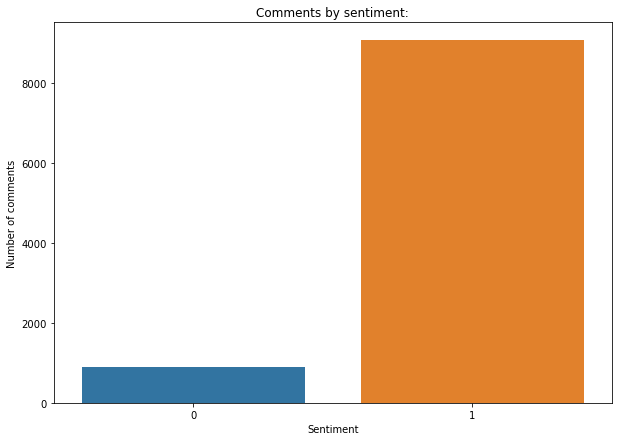

In [26]:
plt.subplots(nrows=1,ncols=1,figsize=(10,7))
ax = sns.countplot(x='Sentiment', data=data)
ax.set_title("Comments by sentiment:")
ax.set_ylabel("Number of comments")

dataPerSentiment = data['Sentiment'].value_counts()
print(f"Amount of data for 'Good' \t: {dataPerSentiment[1]}")
print(f"Amount of data for 'Bad'\t: {dataPerSentiment[0]}")

In [27]:
def balance_dataset(data,sample_number):
    data = data.groupby(['Sentiment']).apply(lambda _df: _df.sample(n=sample_number, random_state=1, replace = True))
    data.reset_index(level=0, drop=True, inplace = True)
    return data
    

In [28]:
sample_number = 1200 
balance = True
replace = True

data = balance_dataset(data = data,
                           sample_number = sample_number)

Text(0, 0.5, 'Number of comments')

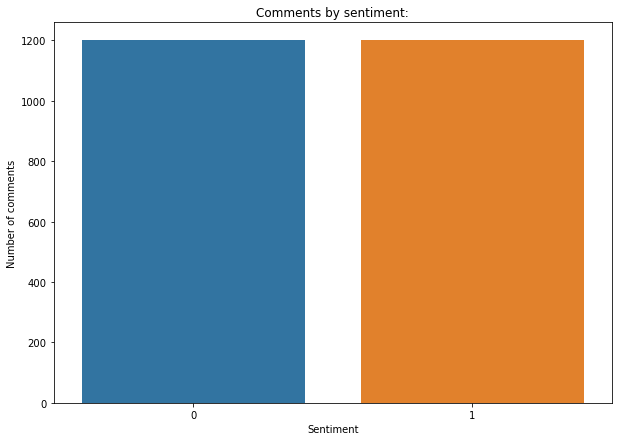

In [29]:
plt.subplots(nrows=1,ncols=1,figsize=(10,7))
ax = sns.countplot(x='Sentiment', data=data)
ax.set_title("Comments by sentiment:")
ax.set_ylabel("Number of comments")

#### Separar entre X/y

In [30]:
objective_var = 'Sentiment'

y_train = data[objective_var].values

X_train = data['Standardized_Text']

In [31]:
X_train

767      appear attract mosquito light chemic toxic tou...
3855     look like work came batteri came littl bit pea...
1350     reason gave feeder two star instead one like g...
11046    took one glanc feeder realiz major design flaw...
10687    high hope dog cat repel deterr keep two austra...
                               ...                        
0        good usa compani stand behind product warranti...
3639     put trap long time ago never caught anyth left...
12651    easi put togeth set upso far issu squirrelsthe...
7999     lawn home infect insect purchas high hope seem...
1999     back wood sure deer ground hog rabbit squash p...
Name: Standardized_Text, Length: 2400, dtype: object

#### Extracción de features

In [32]:
max_num_words = 3000

In [33]:
cv = TfidfVectorizer(
    ngram_range = (2,3), #para capturar el CONTEXTO de las palabras
    max_df = 0.95,
    min_df = 3,
    max_features = max_num_words 
)

In [34]:
cv.fit(X_train)

TfidfVectorizer(max_df=0.95, max_features=3000, min_df=3, ngram_range=(2, 3))

In [35]:
X_train_ = cv.transform(X_train)

### Dejar la test data lista:

In [36]:
def do_text_transformations(data: pd.DataFrame,
                            text_field: str,
                            language: str = "english"):
    # TODO: Clean the text
    data['Text_Clean'] = data[text_field].apply(lambda text: clean_text(text))
    idx = np.array(data[data.Text_Clean == ''].index)
    data.drop(idx, axis = 0, inplace = True)
    
    # TODO: Standardize the text
    data['Standardized_Text'] = data.Text_Clean.apply(lambda text: standardize_text(text, language))

    data['Sentiment'] = data.overall.apply(lambda value: star_sentiment_matching(value))
    data = data.drop(columns = ["overall"])
    
    objective_var = 'Sentiment'
    y = data[objective_var].values
    X = data['Standardized_Text']
    
    return X,y

In [37]:
X_test, y_test = do_text_transformations(data = data_test,
                                      text_field = "reviewText")

In [38]:
X_test_ = cv.transform(X_test)

### Primer modelo

In [39]:
c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100, 1000, 10000]

train_acc = list()
test_acc = list()
for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=2000)
    lr.fit(X_train_, y_train)
    
    train_predict = lr.predict(X_train_)
    test_predict = lr.predict(X_test_)
    
    print ("Accuracy for C={}: {}".format(c, accuracy_score(y_test, test_predict)))
    
    train_acc.append(accuracy_score(y_train, train_predict))
    test_acc.append(accuracy_score(y_test, test_predict))

Accuracy for C=0.01: 0.7607843137254902
Accuracy for C=0.05: 0.7622926093514328
Accuracy for C=0.25: 0.7677224736048266
Accuracy for C=0.5: 0.7716440422322776
Accuracy for C=1: 0.7740573152337858
Accuracy for C=10: 0.77526395173454
Accuracy for C=100: 0.7616892911010558
Accuracy for C=1000: 0.7435897435897436
Accuracy for C=10000: 0.73815987933635


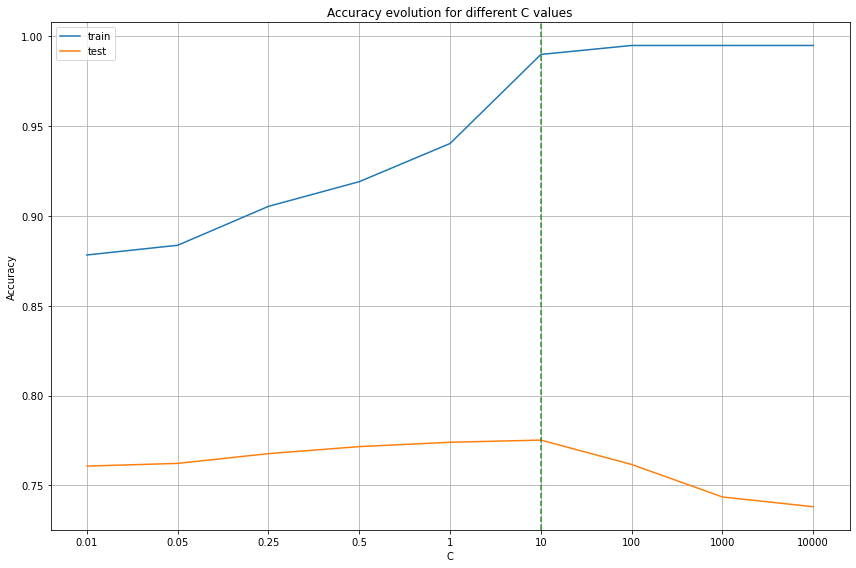

In [40]:
plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.axvline(np.argmax(test_acc), c='g', ls='--', alpha=0.8)
plt.title('Accuracy evolution for different C values')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.xticks(list(range(len(c_params))), c_params)
plt.tight_layout()
plt.show()

In [41]:
lr = LogisticRegression(C=1, solver='lbfgs', max_iter=2000).fit(X_train_, y_train)

In [42]:
print("Train: ",lr.score(X_train_,y_train))
print("Test: ",lr.score(X_test_,y_test))

Train:  0.9404166666666667
Test:  0.7740573152337858


In [43]:
print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_test, test_predict)))

Confussion matrix:
[[ 162  141]
 [ 727 2285]]

Classification report:
              precision    recall  f1-score   support

           0       0.18      0.53      0.27       303
           1       0.94      0.76      0.84      3012

    accuracy                           0.74      3315
   macro avg       0.56      0.65      0.56      3315
weighted avg       0.87      0.74      0.79      3315

Accuracy score:0.73815987933635


Podemos ver que el modelo tiene una accuracy score aceptable para el dataset de training aunque es mejorable. <br>Vemos que tiene una mayor precision para los textos con sentimiento positivo (1) mientras que la precision para predecir el sentimiento de valoraciones negativas es bastante malo. <br> Esto nos hace pensar que cuando el usuario está contento usa palabras mucho más relevantes que aquellos usuarios a los que le ponen una mala calificacion al producto; y por eso el modelo predice mucho mejor sobre ellos. <br> Además, podemos ver que hay bastante overfitting. Vamos a probar con el segundo modelo (Random Forest) a ver si predice mejor.

### Segundo modelo

best mean cross-validation score: 0.752
best parameters: {'max_depth': 12}


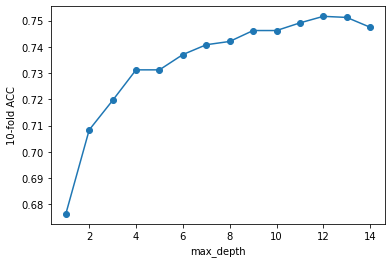

In [44]:
# grid search
maxDepth = range(1,15)
tuned_parameters = {'max_depth': maxDepth}

grid = GridSearchCV(RandomForestClassifier(random_state=0, n_estimators=400), param_grid=tuned_parameters,cv=10) 
grid.fit(X_train_, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth')
plt.ylabel('10-fold ACC')

plt.show()

In [45]:
maxDepthOptimo = 6#grid.best_params_['max_depth']
bagModel = RandomForestClassifier(max_depth=maxDepthOptimo,n_estimators=400).fit(X_train_,y_train)

In [46]:
print("Train: ",bagModel.score(X_train_,y_train))
print("Test: ",bagModel.score(X_test_,y_test))

Train:  0.835
Test:  0.8250377073906485


In [47]:
test_predict_RF = bagModel.predict(X_test_)

print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict_RF)))
print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict_RF)))
print('Accuracy score:{}'.format(accuracy_score(y_test, test_predict_RF)))

Confussion matrix:
[[ 127  176]
 [ 404 2608]]

Classification report:
              precision    recall  f1-score   support

           0       0.24      0.42      0.30       303
           1       0.94      0.87      0.90      3012

    accuracy                           0.83      3315
   macro avg       0.59      0.64      0.60      3315
weighted avg       0.87      0.83      0.85      3315

Accuracy score:0.8250377073906485


Vemos que el accuracy ha mejorado bastante teniendo casi un 83% en test, por lo que podemos decir que tenemos un buen modelo que capta el sentimiento de los usuarios que valoran los productos en amazon. <br> Vemos que la precision sobre valoraciones consideradas positivas (1) sigue siendo muy alta, y la de las valoraciones negativas (0) ha subido pero sigue siendo muy baja respecto a la positiva.
<br> Además, en este modelo no tenemos un sobreajuste a los datos por lo que es mucho más robusto. 

*------------------------------------------------------------*<br>
Vemos que el accuracy del modelo baja a 0.79 de accuracy, por lo podemos reafirmar la teoría de que no quitar las stopwords entorpece la predicción del algoritmo para detectar el sentimiento de una review.

### Guardamos el mejor modelo

Para hacer pruebas sobre como aplica este modelo recibiendo como input reviews de otra temática en amazon, vamos a guardarlo y meterle otros datos:

In [48]:
import pickle

In [49]:
filename = 'rf'
pickle.dump(bagModel, open(filename, 'wb'))

--------

In [50]:
import os 
path = os.path.dirname(os.path.realpath('AmparoAlias_sentiment_analysis')) 
print(path)
import sys 
sys.path.insert (0, path) 

/Users/amparoalias/Desktop/Keepcoding/nlp


In [51]:
import utils 
from utils import do_text_transformations

In [52]:
filename = 'rf'
bagModel = pickle.load(open(filename, 'rb'))

In [53]:
filename = "data/pet_supplies.json"
reviews = []
for line in open(filename, 'r'):
    reviews.append(json.loads(line))
reviews = json.dumps(reviews)

In [54]:
data2 = pd.read_json(reviews)

In [55]:
data2 = data2[['reviewText', 'overall']]

In [56]:
n = 1500
data2 = data2.sample(n=n, random_state=2)

In [57]:
data2 = do_text_transformations(data = data2, text_field = 'reviewText')

In [58]:
objective_var = 'Sentiment'

y = data[objective_var].values

X = data['Standardized_Text']

In [59]:
X_ = cv.transform(X)

In [60]:
prediction = bagModel.predict(X_)

In [61]:
print('Confussion matrix:\n{}'.format(confusion_matrix(y, prediction)))
print('\nClassification report:\n{}'.format(classification_report(y, prediction)))
print('Accuracy score:{}'.format(accuracy_score(y, prediction)))

Confussion matrix:
[[ 867  333]
 [  63 1137]]

Classification report:
              precision    recall  f1-score   support

           0       0.93      0.72      0.81      1200
           1       0.77      0.95      0.85      1200

    accuracy                           0.83      2400
   macro avg       0.85      0.83      0.83      2400
weighted avg       0.85      0.83      0.83      2400

Accuracy score:0.835


Vemos que para otras temáticas este modelo predice bastante bien. <br> Incluso pilla mejor los comentarios negativos. 